**1. Setup and Load Data**

1.1 Install and add dependencies

In [1]:
import tensorflow as tf
import os

In [13]:
# os.path.join('data', 'train', 'AI_GENERATED')
# os.path.join('data', 'train', 'NON_AI_GENERATED')

#AVOID OOM ERRORS BY SETTING CPU MEMORY CONSUMPTION GROWTH
# cpus = tf.config.experimental.list_physical_devices('CPU')
# for cpu in cpus:
#     tf.config.experimental.set_memory_growth(cpu, True)

1.2 Remove dodgy images

In [2]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [3]:
data_dir = os.path.join('data')
os.listdir(data_dir)

['AI_GENERATED', 'NON_AI_GENERATED']

In [4]:
image_exts = ['jpg']

In [5]:
for image_class in os.listdir(data_dir):
    print(image_class)

AI_GENERATED
NON_AI_GENERATED


In [6]:
#AI = 0
#HUMAN = 1

1.3 Load data

In [ ]:
tf.data.Dataset??

In [8]:
import numpy as np

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 18618 files belonging to 2 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

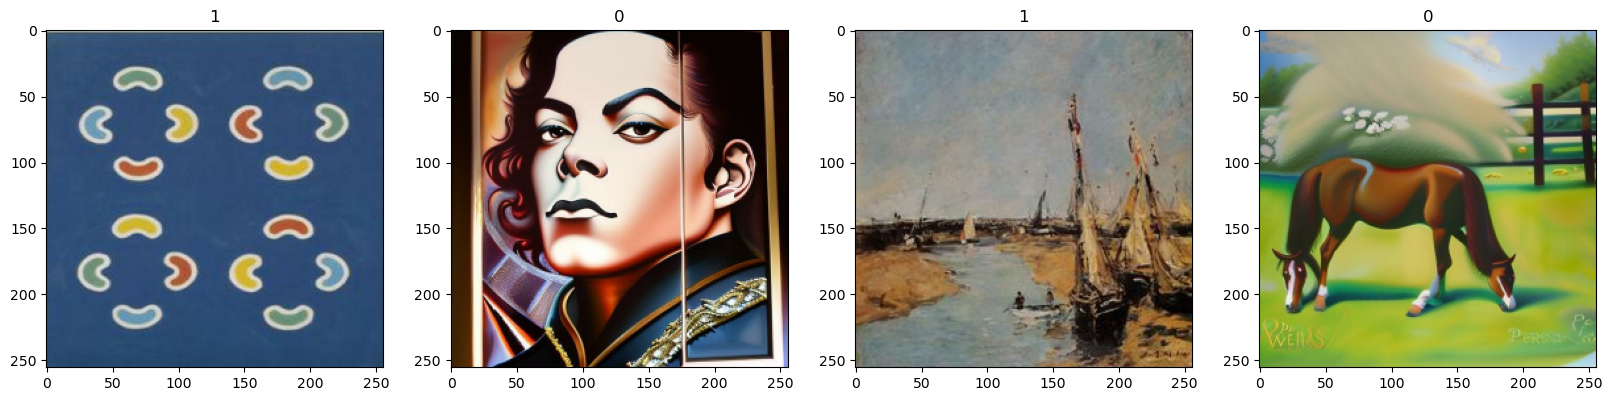

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

*2. Preprocessing Data*

2.1 Scale data

In [13]:
data = data.map(lambda x, y: (x/255, y))

In [14]:
data.as_numpy_iterator().next()[0].max()

1.0

2.2 Split data

In [15]:
len(data)

582

In [16]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

*3. Deep Model*

3.1 Build Deep Learning Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [19]:
model = Sequential()

In [20]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [21]:
#tf.optimizers
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [22]:
#model.summary()

3.2 Train

In [23]:
logdir='logs'

In [24]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [25]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
407/407 [==============================] - 307s 746ms/step - loss: 0.3624 - accuracy: 0.8310 - val_loss: 0.2886 - val_accuracy: 0.8712
Epoch 2/20
407/407 [==============================] - 312s 766ms/step - loss: 0.2554 - accuracy: 0.8855 - val_loss: 0.2446 - val_accuracy: 0.8941
Epoch 3/20
407/407 [==============================] - 310s 762ms/step - loss: 0.2081 - accuracy: 0.9098 - val_loss: 0.2598 - val_accuracy: 0.8755
Epoch 4/20
407/407 [==============================] - 317s 778ms/step - loss: 0.1572 - accuracy: 0.9349 - val_loss: 0.2436 - val_accuracy: 0.8987
Epoch 5/20
407/407 [==============================] - 289s 709ms/step - loss: 0.1169 - accuracy: 0.9534 - val_loss: 0.3927 - val_accuracy: 0.8712
Epoch 6/20
407/407 [==============================] - 287s 704ms/step - loss: 0.0853 - accuracy: 0.9654 - val_loss: 0.4350 - val_accuracy: 0.8895
Epoch 7/20
407/407 [==============================] - 290s 711ms/step - loss: 0.0475 - accuracy: 0.9819 - val_loss: 0.4669 -

3.3 Plot Performance

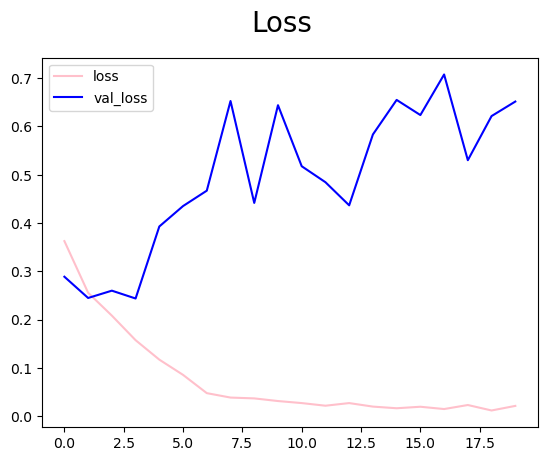

In [28]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='pink', label='loss')
plt.plot(hist.history['val_loss'], color='blue', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

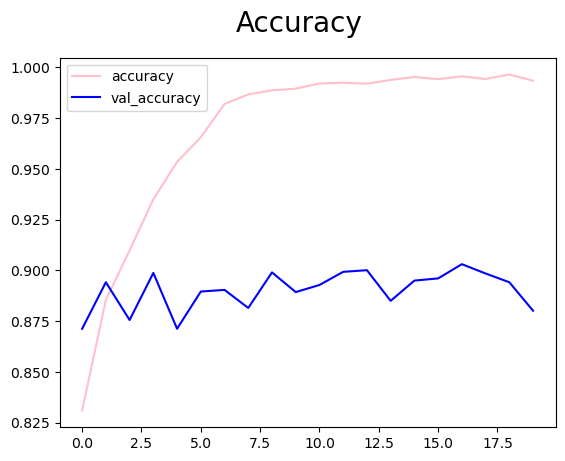

In [29]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='pink', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='blue', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

*4.Evaluate Performance*

4.1 Evaluate

In [30]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [31]:
pre =Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 178ms/step


In [34]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()})')

Precision: 0.8690476417541504, Recall: 0.8488371968269348, Accuracy: 0.8706896305084229)


4.2 Test

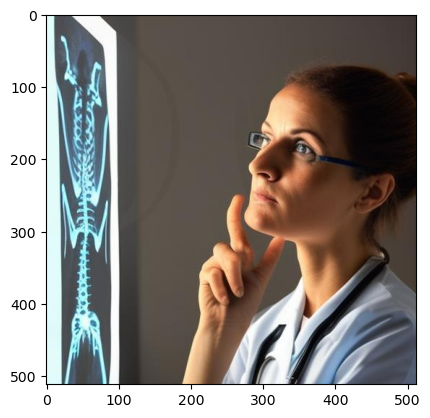

In [52]:
img = cv2.imread('104.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

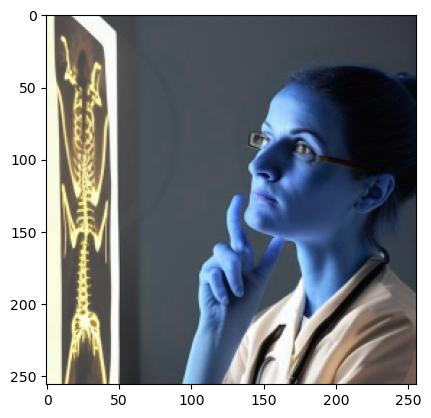

In [53]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [54]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 35ms/step


In [55]:
yhat

array([[8.81356e-17]], dtype=float32)

In [59]:
if yhat > 0.5:
    print(f'HUMAN-MADE-ART')
else:
    print(f'AI-GENERATED-ART')

AI-GENERATED-ART


In [60]:
from tensorflow.keras.models import load_model

In [61]:
model.save(os.path.join('models', 'art_classification.h5'))

c:\Users\merie\anaconda3\envs\ml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [63]:
new_model = load_model(os.path.join('models', 'art_classification.h5'))

In [64]:
yhat_new = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 120ms/step


In [65]:
if yhat_new > 0.5:
    print(f'HUMAN-MADE-ART')
else:
    print(f'AI-GENERATED-ART')

AI-GENERATED-ART
